## Imports

In [1]:
import numpy as np


import torch



if torch.cuda.is_available():
    DEVICE = 'cuda'
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    DEVICE = 'cpu'

print('Using {}'.format(DEVICE))

INPUT_SIZE = 28*28
BATCH_SIZE = 32
SEQ_LENGTH = 9


import mnist
import plot
import Bathtub

Using cpu


## Set up hyperparameters & load training data


In [2]:
log_betas = list(np.logspace(-10, 0, 11))
betas = list(np.linspace(0, 1, 11).round(1)) # linear scale
training_set, validation_set, test_set = mnist.load(val_ratio=0.0)

HIDDEN_SIZE = 64

## Analysis: term (a)
We first analyse term (a): the synaptic transmission + postsynaptic unit activity, i.e., suppose we have the model output at time step $t$, then we define the loss at timestep $t$ as:
$$ Loss = \sum_t \frac{1}{n} \left(\sum_i^n \beta|s_i^t| + |h_i^t|\right)$$
Where $\textbf{s}^t = |\textbf{W}||\textbf{h}^{t-1}|$ is the synaptic transmission of the previous activity  at time step $t$, i.e. the 'responsibility'  of lateral connectivity in causing $h_i^t$.

In [3]:
term = 'a'

### load bathtubs and retrieve train & test loss performance at final epoch

In [4]:
tubs, train_losses, test_losses = [], [], []
log_tubs, log_train, log_test = [], [], []
for beta in betas:
    tub = Bathtub.State(
        activation_func=torch.nn.ReLU(),
        optimizer=torch.optim.Adam,
        lr=1e-4,
        beta=beta,
        input_size=INPUT_SIZE,
        hidden_size=INPUT_SIZE + HIDDEN_SIZE,
        title="bathtub/64u-seq9-relu-transmit-act-"+str(beta),
        device=DEVICE)
    tub.load()
    train_losses.append(tub.results['train loss'][-1])
    test_losses.append(tub.results['test loss'][-1])
    tubs.append(tub)
for beta in log_betas:
    log_tub = Bathtub.State(
        activation_func=torch.nn.ReLU(),
        optimizer=torch.optim.Adam,
        lr=1e-4,
        beta=beta,
        input_size=INPUT_SIZE,
        hidden_size=INPUT_SIZE + HIDDEN_SIZE,
        title="bathtub/64u-seq9-relu-transmit-act-"+str(beta),
        device=DEVICE)
    log_tub.load()
    log_train.append(log_tub.results['train loss'][-1])
    log_test.append(log_tub.results['test loss'][-1])
    log_tubs.append(log_tub)

### display training losses over beta
Note that in this instance a lower loss does not necessarily translate into better results betas are on linear-scale since the interesting changes appeared to happen in $$\beta \in [0.1, 1]$$

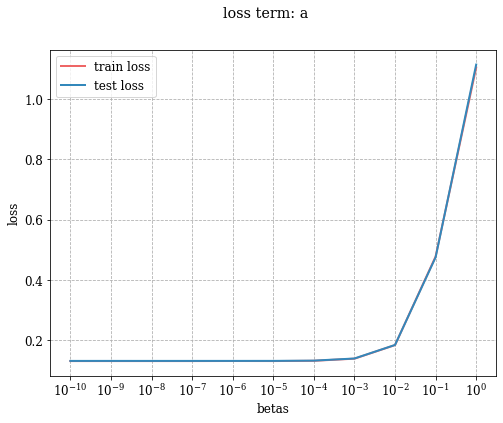

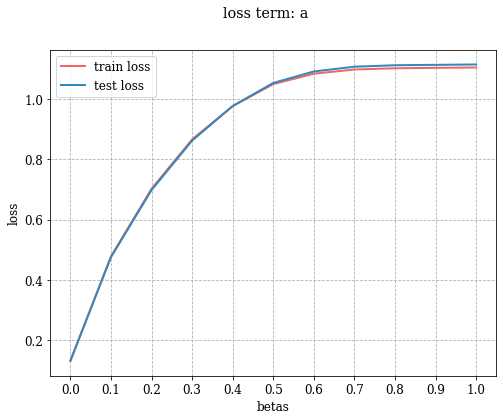

In [5]:
plot.beta_loss(log_betas, log_train, log_test, title=term, scale='log')
plot.beta_loss(betas, train_losses, test_losses, title=term)

### display mean absolute presynaptic and postsynaptic activity of final time step
here the mean absolute presynaptic activity is defined as:
$$ \frac{1}{n} \sum_{i}|a_i|$$
Where $a_i$ is the presynaptic activity of a unit $i$ and $n$ denotes the number of units. 
The global median denotes the median image of the entire data set, while the global median is the mean over the median images of each category. 
The mean postsynaptic activity is defined as:
$$ \frac{1}{n} \sum_{i}|h_i|$$
Where $h_i = ReLU(a_i)$. 

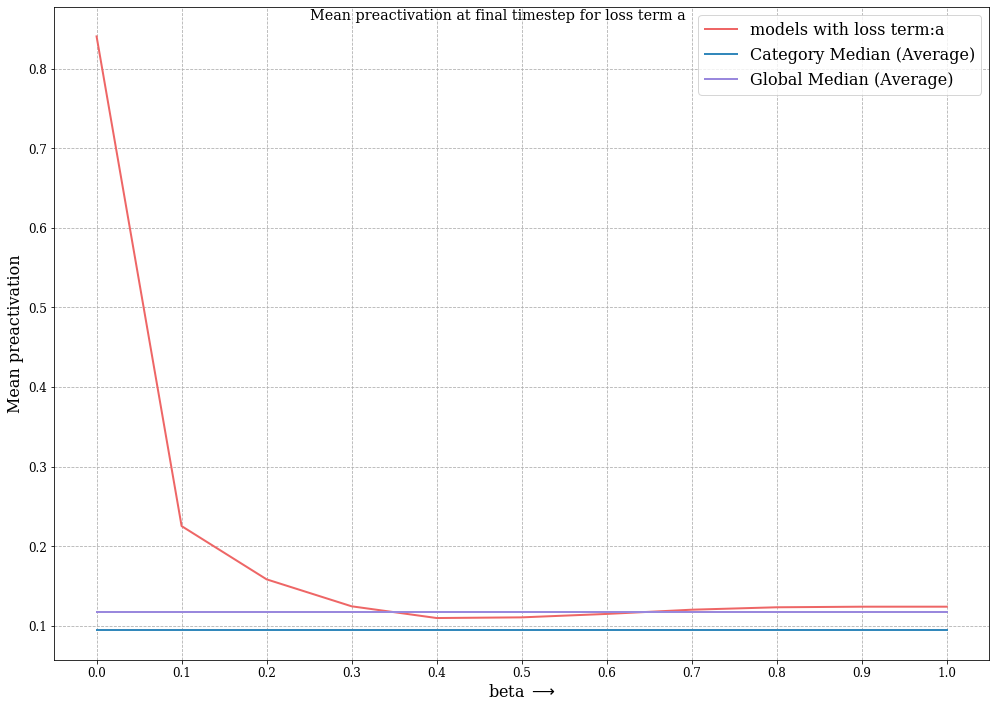

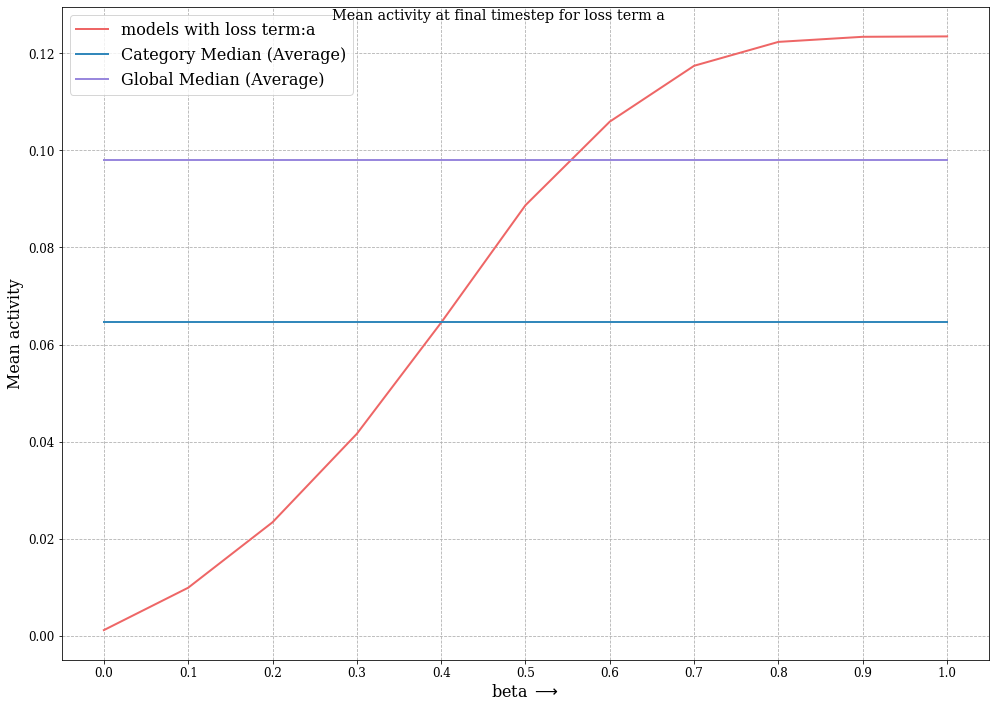

In [6]:
#plot.final_mea(log_betas, log_tubs, training_set, test_set, title=term, scalex='log')
plot.final_mea(betas, tubs, training_set, test_set, title=term)
plot.final_mea(betas, tubs, training_set, test_set, title=term, activity='post')

### display mean synaptic transmission (t=9)
the real synaptic transmission at time step $t$ is defined as:
$$ s_t = \frac{1}{n} \sum_{i} \sum_{j} |w_{ji}||h_i^{t-1}|$$
Where $h_i^{t-1}$ is the postsynaptic unit activity of unit i at timestep $t-1$, $w_{ji}$ is a presynaptic connection from unit $j$ to $i$
The respective median transmissions are defined by computing the median images and taking the absolute sum i.e.:
$$s_{med} = \frac{1}{n} \sum_{i} |x_i|$$
Where $x_i$ is a pixel of either the category or global median image and $n$ are the number of units in the network. 

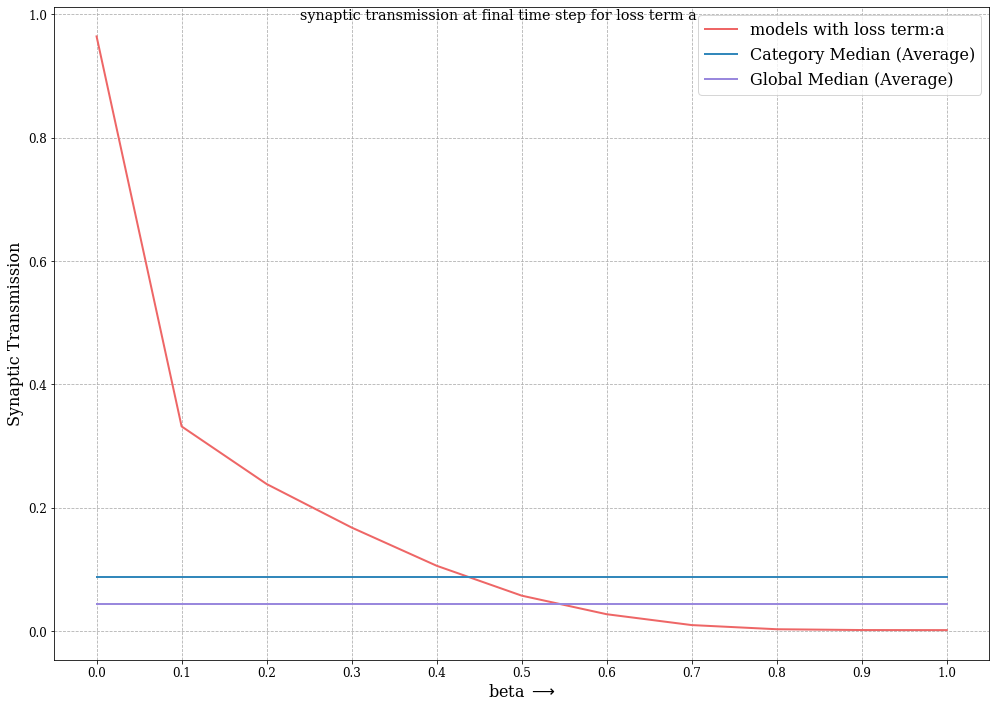

In [7]:
plot.final_synaptrans(betas, tubs, training_set, test_set, title=term)

### display mean absolute activity over time
Based on the mean absolute activities and synaptic transmission, we find an optimum around $\beta=0.4$, where mean absolute activities intersect the category medians and synaptic transmission is minimal. 

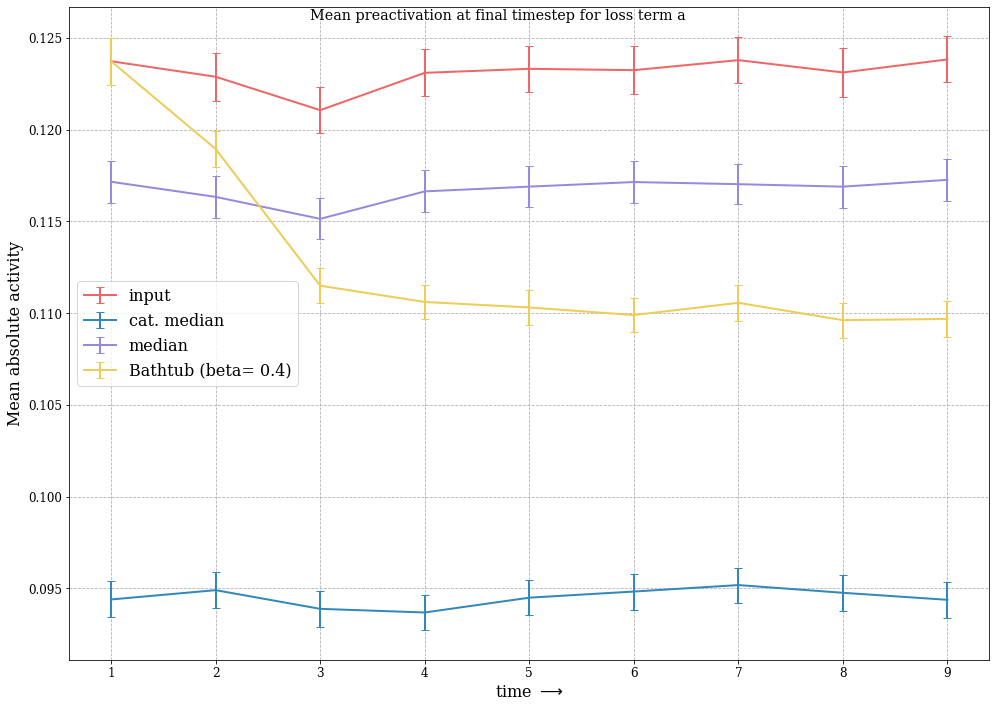

In [8]:
plot.mean_activity([betas[4]],[tubs[4]], training_set, test_set)

### display synaptic transmission over time

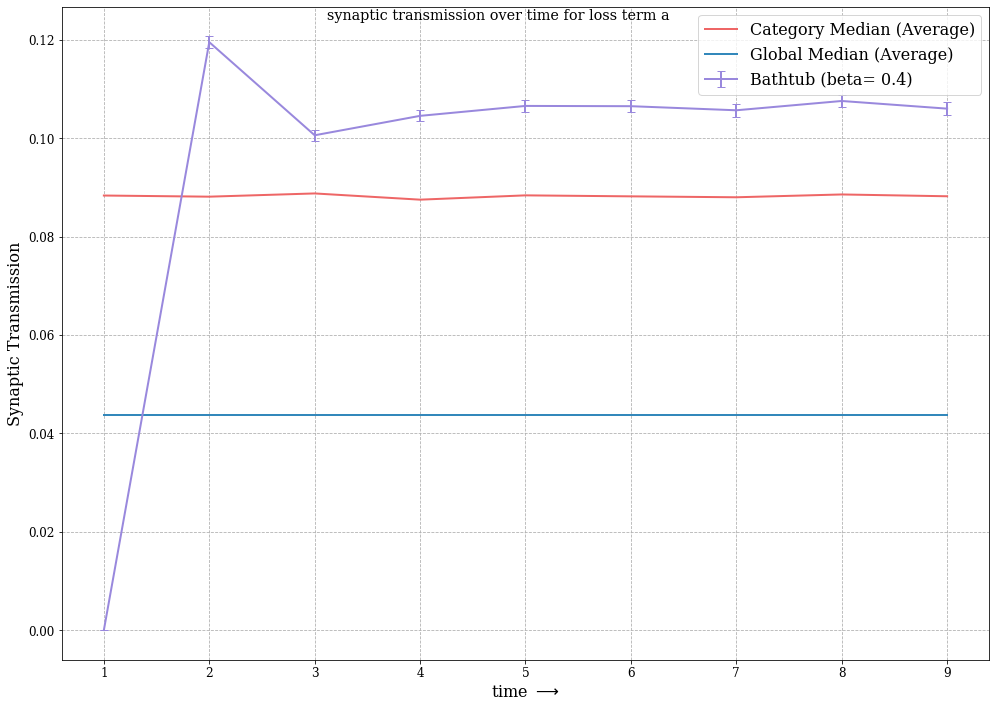

In [9]:
plot.mean_synaptrans([betas[4]], [tubs[4]], training_set, test_set)

### display input & prediction drive
In the following panes we show input and prediction drive for several betas, input and prediction drive are defined as:
$$<x^+> = \frac{1}{n} \sum_b ReLU(\textbf{x}^{t = 9})$$
$$<p^+> = \frac{1}{n} \sum_b ReLU(\textbf{p}^{t = 9})$$
Where $b$ is a sum over the batches, $\textbf{x}^{t = 9}$ is the input batch at the final time step and $\textbf{p}^{t=9} = \textbf{W}\cdot\textbf{h}^{t=9-1}$ is the prediction of the units at the final timestep 

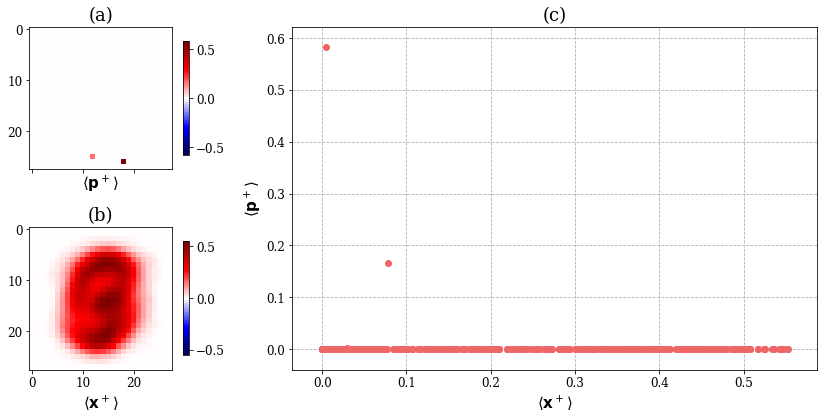

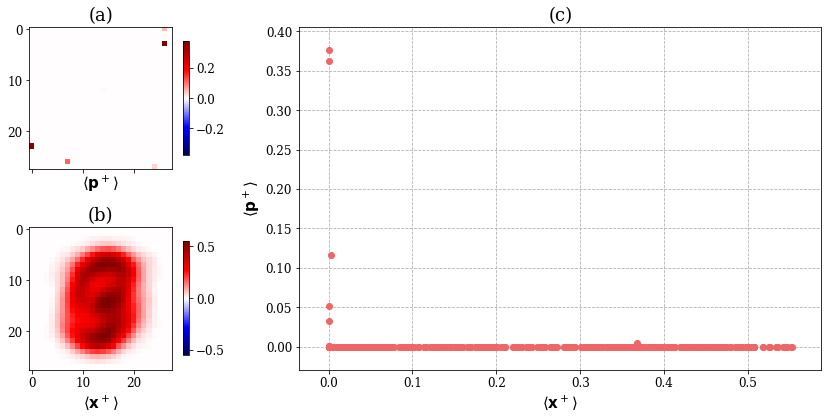

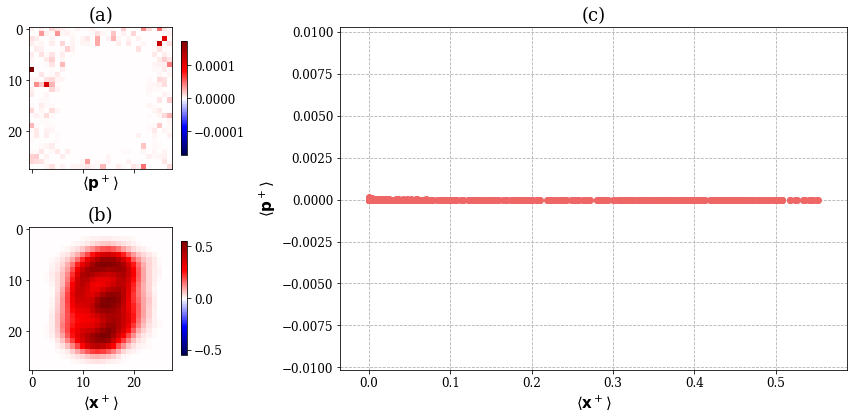

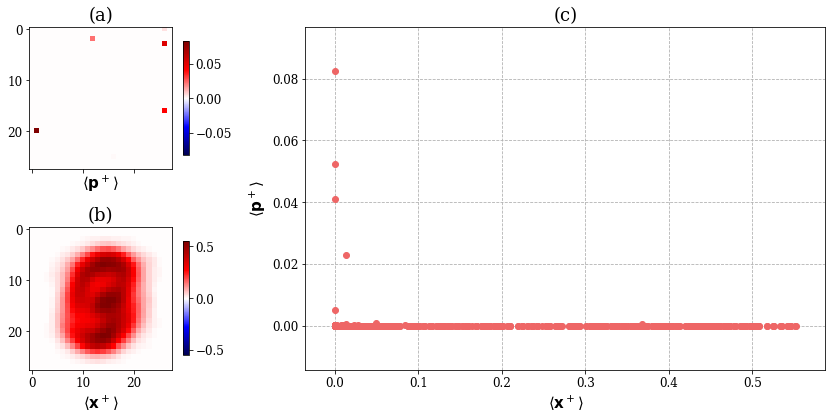

In [22]:
ms_tubs = []
for beta in betas:
    ms = Bathtub.State(
        activation_func=torch.nn.ReLU(),
        optimizer=torch.optim.Adam,
        lr=1e-4,
        beta=beta,
        input_size=INPUT_SIZE,
        hidden_size=INPUT_SIZE,
        title="bathtub/seq9-relu-transmit-act-"+str(beta),
        device=DEVICE)
    ms.load()
    ms_tubs.append(ms)
    
a_tubs = ms_tubs[0:2] + ms_tubs[-1:]
b_tub = ms_tubs[4]
for a_tub in a_tubs:
    plot.xdrive_pdrive(a_tub, test_set, save=False)
plot.xdrive_pdrive(b_tub, test_set, save=False)



### Show predictions of best bathtubs

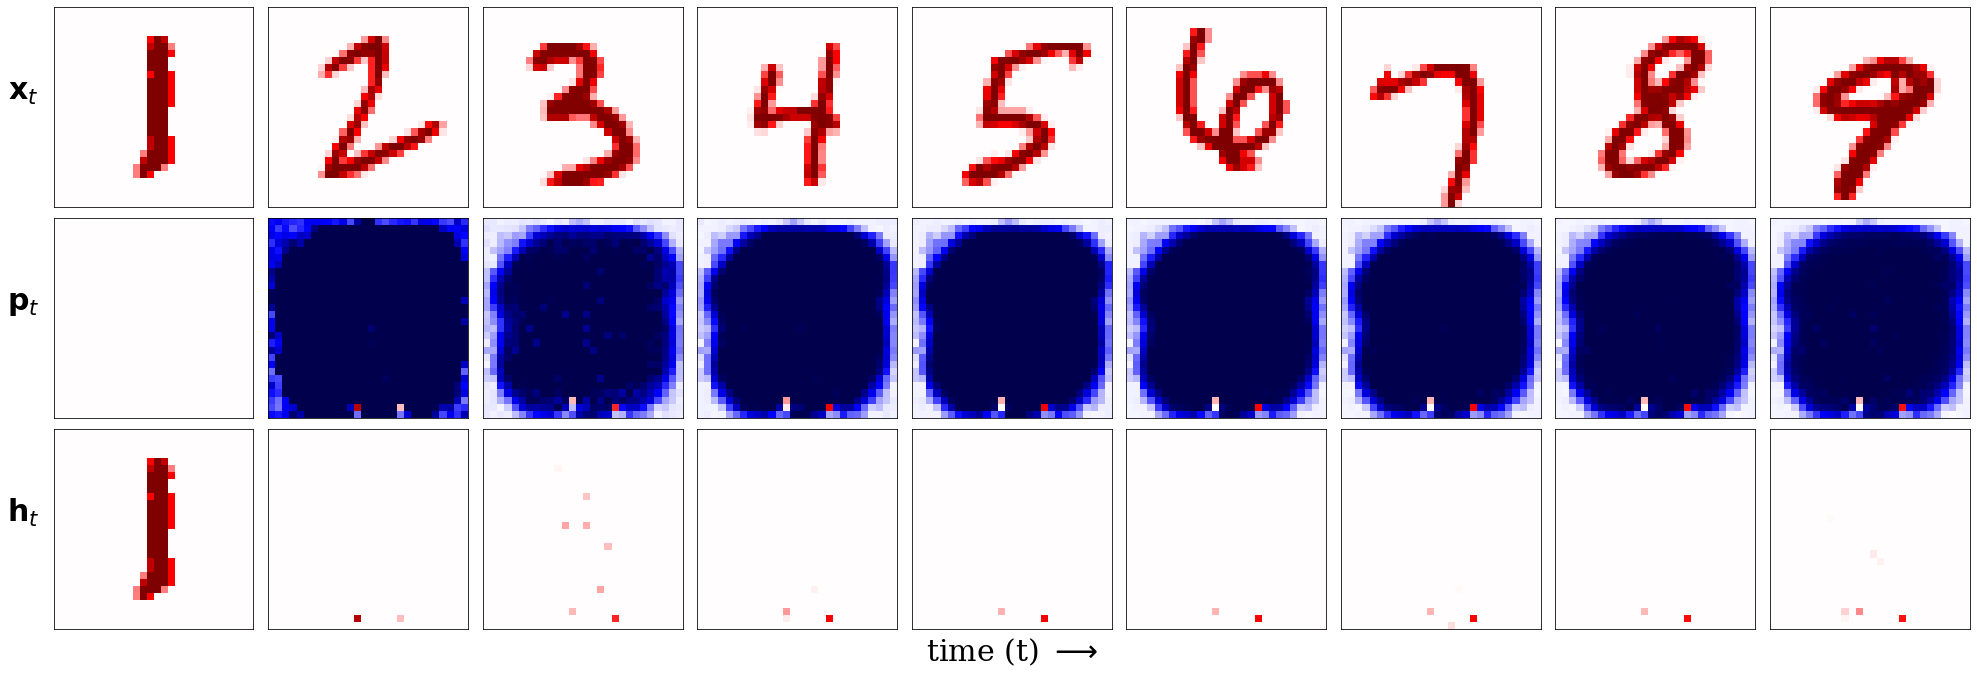

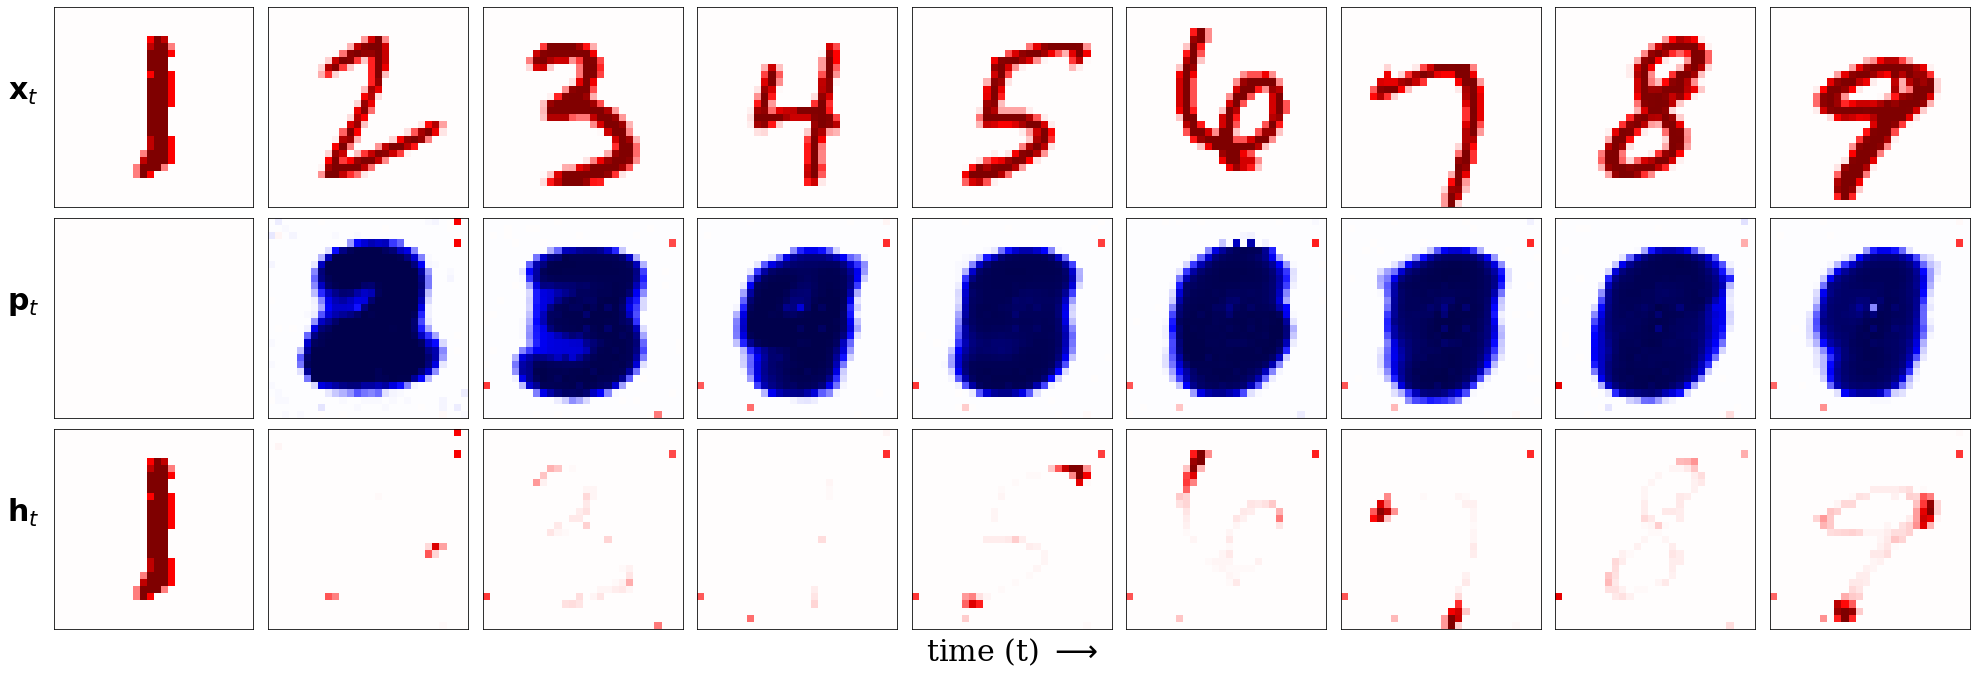

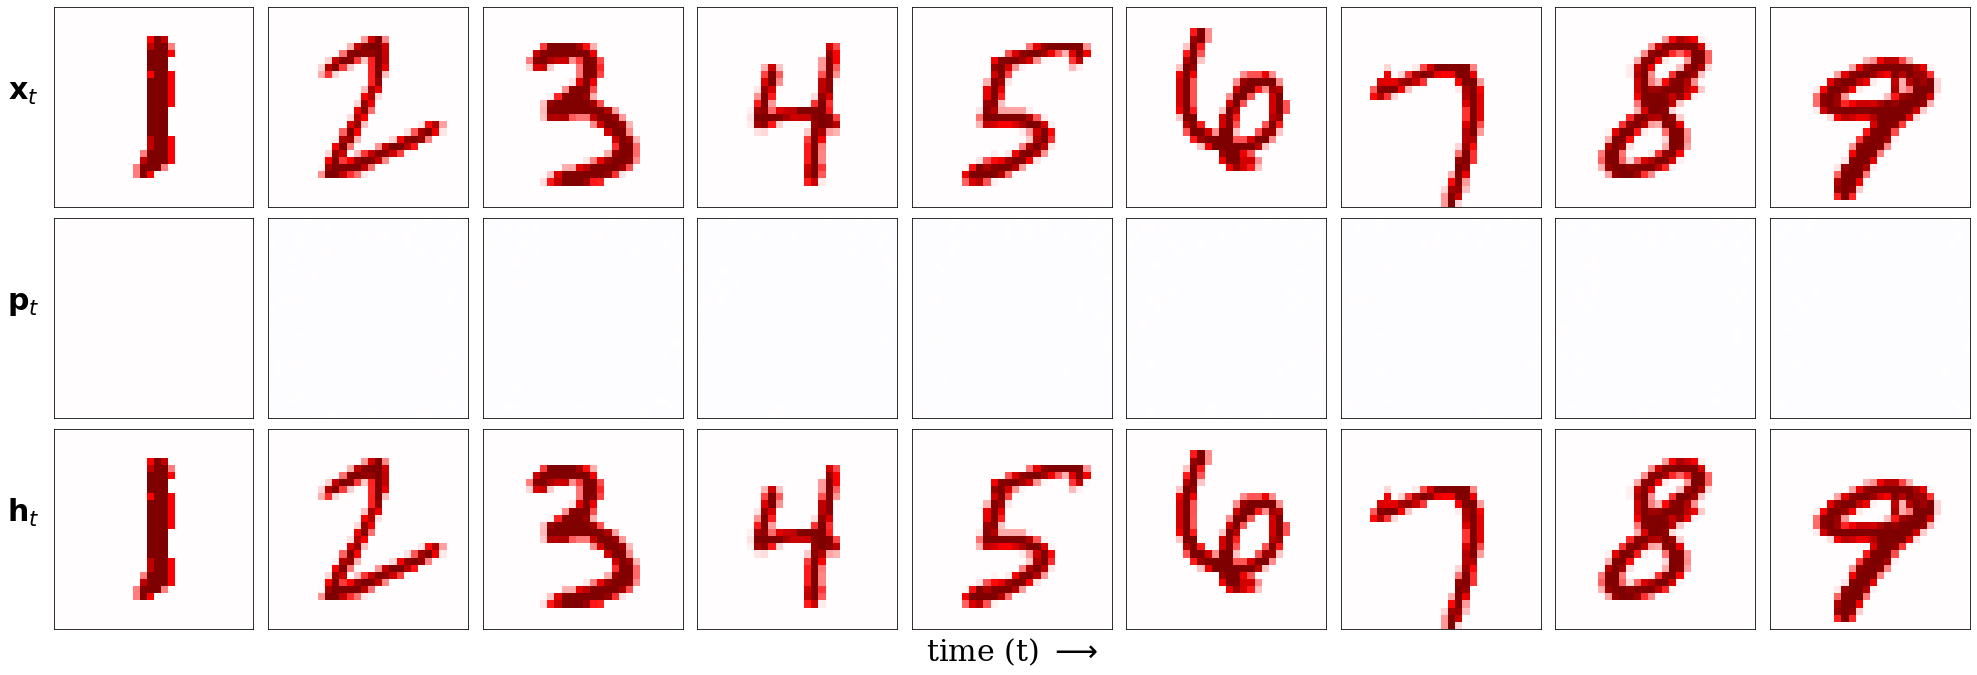

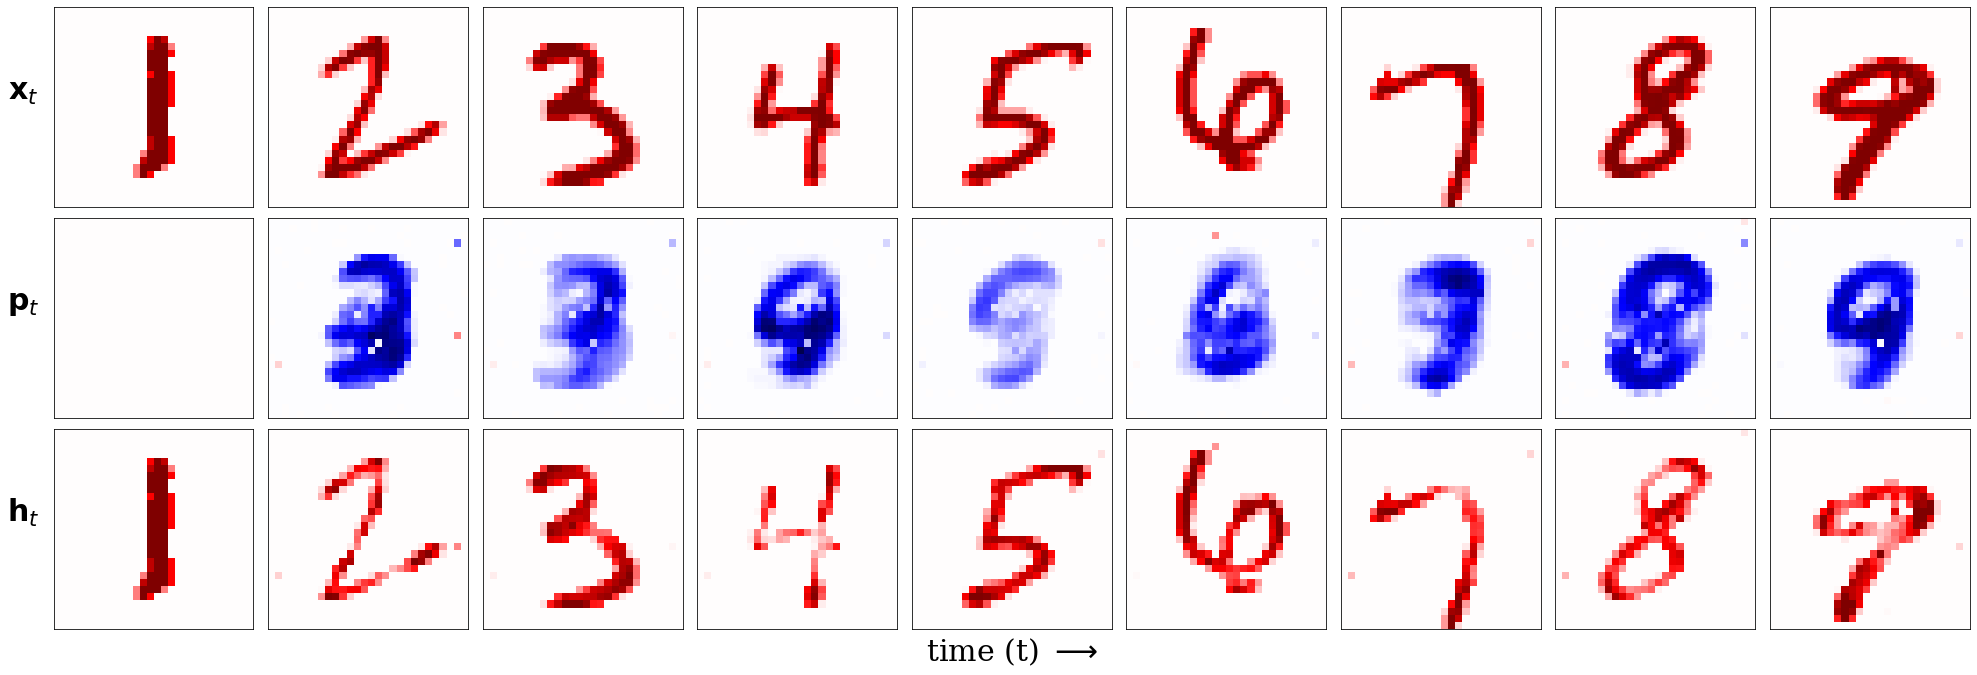

In [21]:
a_tubs = ms_tubs[0:2] + ms_tubs[-1:]
b_tub = ms_tubs[4]
for a_tub in a_tubs:
    plot.example_sequence_state(a_tub, test_set, save=False)
plot.example_sequence_state(b_tub, test_set, save=False)

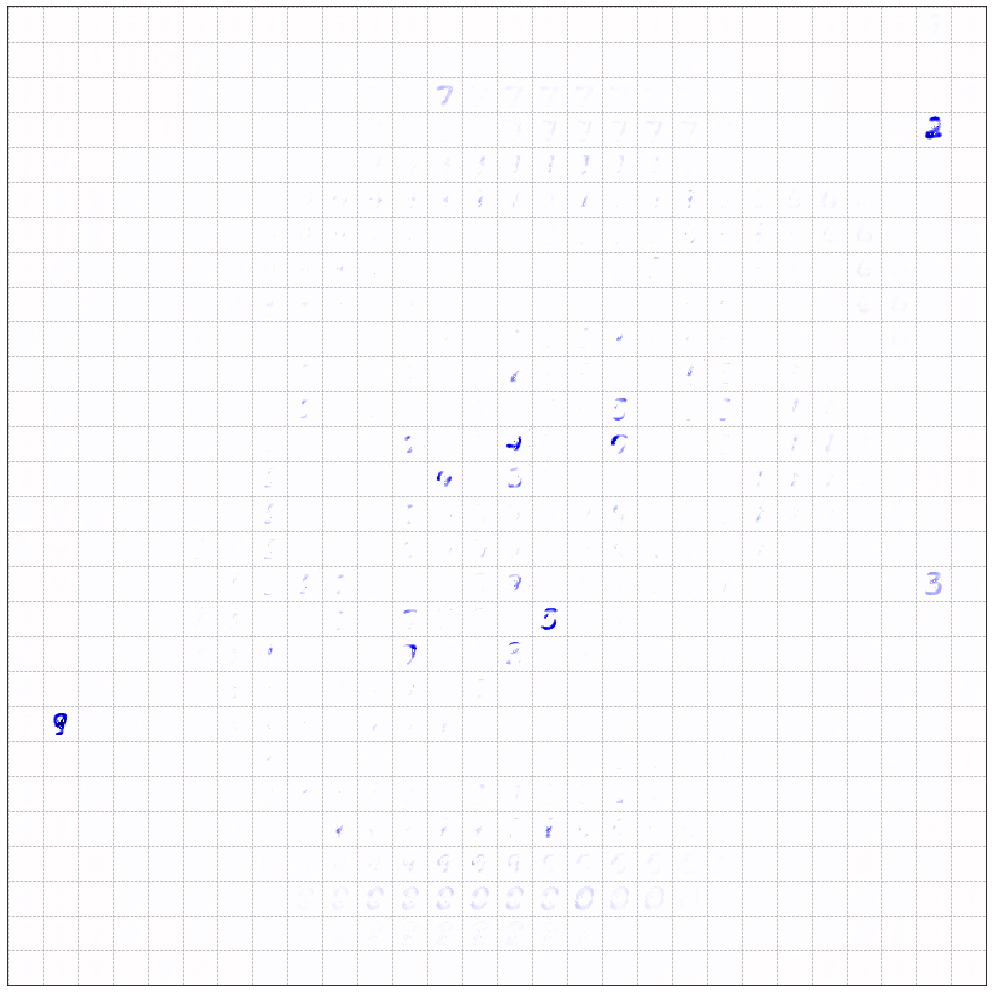

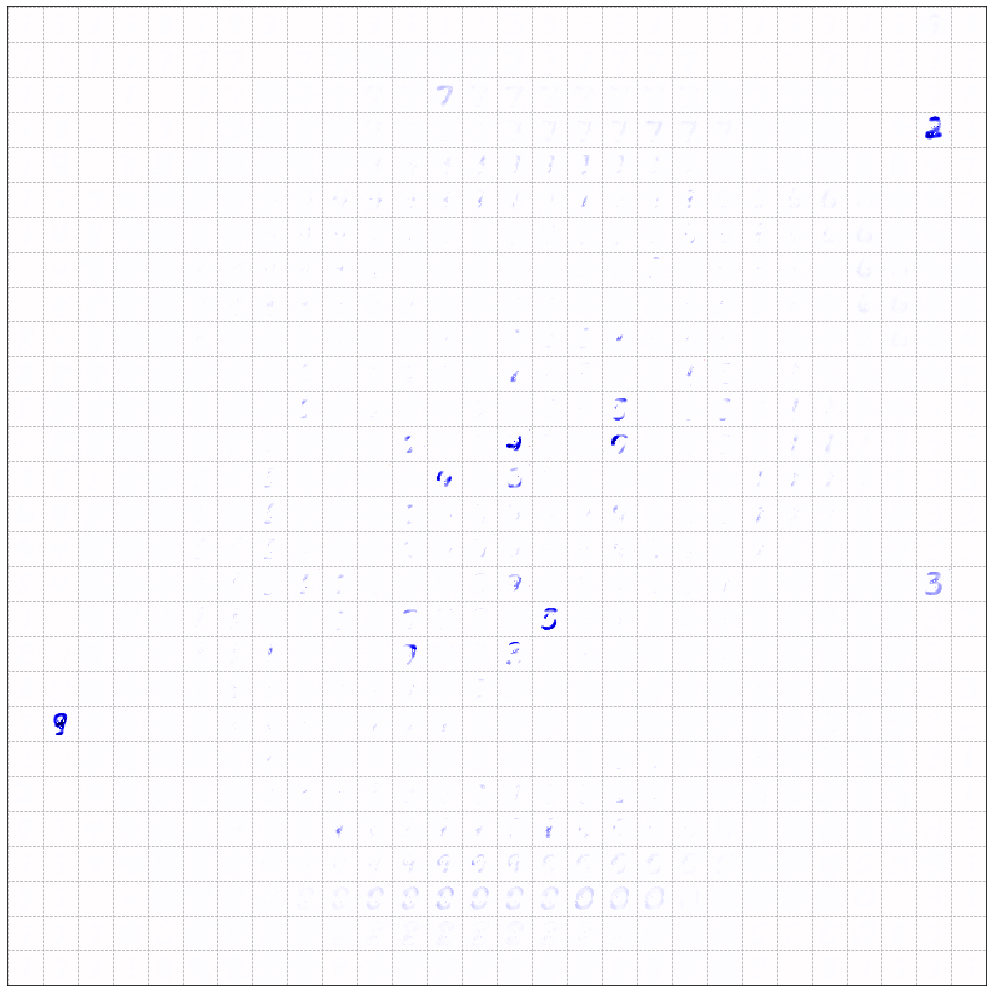

In [12]:
plot.weights_mean_activity(b_tub, test_set, save=False)